In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import Rbf, interp1d
from scipy import integrate
import numpy as np
import os
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.signal import find_peaks
import matplotlib.cm as cm
import matplotlib.colors as colors

## Load DLS

In [2]:
df = pd.read_excel('../Data/DLS/Assembly_kinetics_data.xlsx').values[:,5:].T
data = df.astype('float')
#df = np.flip(df)
sizes = data[1:71,0]
intensity = data[71:,:]
n_samples = 19
for i in range(0,n_samples):
    sample_int = intensity[:,i*3:i*3 + 3]
    avg = np.mean(sample_int, axis=1)
    if i == 0:
        avg_data_silica = avg.reshape(-1,1)
    else:
        avg_data_silica = np.hstack((avg_data_silica, avg.reshape(-1,1)))

In [4]:
def gaus(x,a,mu,sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

def calculate_max_wv(sizes, spec):
    peak_pos = find_peaks(spec, height=0.75)[0][0]
    lower = 8
    upper = 8
    scaler = MinMaxScaler()
    coords = spec[int(peak_pos-lower):int(peak_pos+upper)].reshape(-1,1)
    coords = scaler.fit(coords).transform(coords)*100
    sizes = np.log10(sizes)
    new_wv = sizes[int(peak_pos-lower):int(peak_pos+upper)]
    
    angles = new_wv - np.median(new_wv)
    data = coords
    angles = np.array(angles).flatten()
    data = np.array(data).flatten()

    n = len(data)  ## <---
    mean = np.sum(data*angles)/n
    sigma = np.sqrt(np.sum(data*(angles-mean)**2)/n)

    popt,pcov = curve_fit(gaus,angles,data)#,p0=[0.18,mean,sigma])  ## <--- leave out the first estimation of the parameters
    xx = np.linspace(np.min(angles), np.max(angles), 100)  ## <--- calculate against a continuous variable

    normal_fit = gaus(xx,*popt)
    xx_wv = xx + np.median(new_wv)
    #fig, ax = plt.subplots()
    plt.plot(xx_wv, normal_fit,'r',label='Fit')  ## <--- plot against the contious variable
    plt.scatter(new_wv, data)
    peak_position = xx_wv[np.argmax(normal_fit)]
    peak_position = 10**peak_position
    plt.title('Peak Position: ' + str(peak_position)[0:3])
    return peak_position

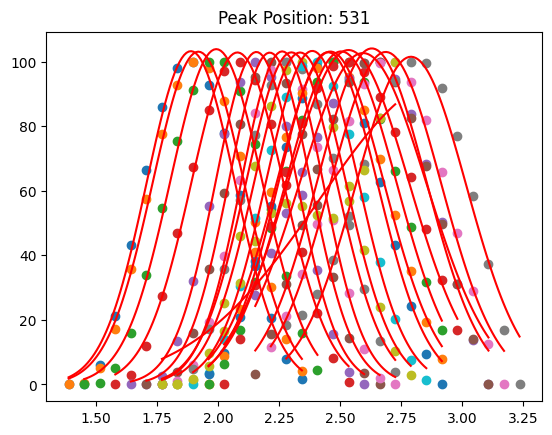

In [5]:
DLS_size = []
for i in range(avg_data_silica.shape[1]):
    DLS_spec = avg_data_silica[:,i]
    peak_position = calculate_max_wv(sizes, DLS_spec)
    # plt.plot(sizes, DLS_spec)
    # plt.vlines(peak_position, 0, 10)
    # plt.xscale('log')
    DLS_size.append(peak_position)
DLS_size = np.array(DLS_size)

In [6]:
times = np.linspace(0, 120, 19)
times = times[:-1]

In [7]:
DLS_peak = DLS_size[:-1]

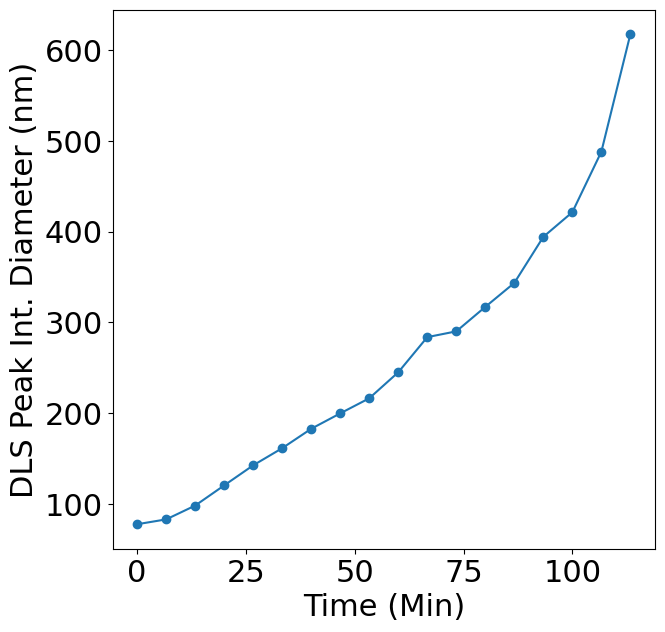

In [ ]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(times, DLS_peak)
ax.scatter(times, DLS_peak)
ax.set_ylabel('DLS Peak Int. Diameter (nm)')
ax.set_xlabel('Time (Min)')
#plt.savefig('../Figures/Kinetics_Experiment_DLS_size.png', dpi=600, bbox_inches="tight")

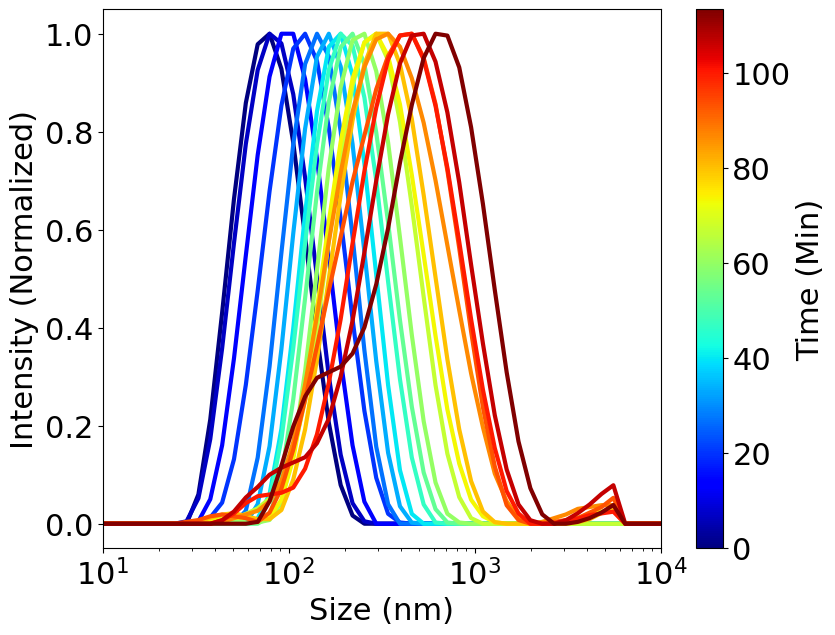

In [ ]:

norm = colors.Normalize(vmin=np.min(times), vmax=np.max(times))
cmap = cm.jet
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(9,7))
for i in range(avg_data_silica.shape[1]-1):
    DLS_spec = avg_data_silica[:,i]
    ax.plot(sizes, DLS_spec/np.max(DLS_spec), color=sm.to_rgba(times[i]), linewidth=3)
    ax.set_xscale('log')
ax.set_xlim([1e1, 1e4])
ax.set_ylabel('Intensity (Normalized)')
ax.set_xlabel('Size (nm)')
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Time (Min)')
#plt.savefig('../Figures/Kinetics_Experiment_DLS.png', dpi=600, bbox_inches="tight")